# ClearAccess IP Proposal

IP Database Semantic Search. We will propose a method to search a database of patent filings and return a listed ranked by semantic relevance. 

## Latent Semantic Analysis

* Semantic analysis adds structure to unstructured text. It helps uncover hidden relationships and automatically standardises/normalises metadata across large document collections.
* Latent Semantic Analysis (LSA) is a framework for analyzing text using matrices
* Find relationships between documents and terms within documents
* Used for document **classification**, **clustering**

## Vectorizing text
* Most **machine-learning** and statistical algorithms only work with structured, tabular data
* A simple way to add structure to text is to use a document-term matrix
* Named Entity Recognition - Extraction of People, Places, Organisations, Times, Email addresses.. from text.

## Document-term matrix

We will model each patent document as a row in a matrix:

In [2]:
# Initial import statements
import sklearn
import numpy
from __future__ import print_function
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
import pandas as pd
import warnings
# Suppress warnings from pandas library
warnings.filterwarnings("ignore", category=DeprecationWarning,
module="pandas", lineno=570)

In [25]:
example = ["Machine learning is super fun",
"Python is super, super cool",
"Statistics is cool, too",
"Data science is fun",
"Python is great for machine learning",
"I like football",
"Football is great to watch"]
vectorizer = CountVectorizer(min_df = 1, stop_words = 'english')
dtm = vectorizer.fit_transform(example)
pd.DataFrame(dtm.toarray(),index=example,columns=vectorizer.get_feature_names
()).head(10)

,cool,data,football,fun,great,learning,like,machine,python,science,statistics,super,watch
Machine learning is super fun,0,0,0,1,0,1,0,1,0,0,0,1,0
"Python is super, super cool",1,0,0,0,0,0,0,0,1,0,0,2,0
"Statistics is cool, too",1,0,0,0,0,0,0,0,0,0,1,0,0
Data science is fun,0,1,0,1,0,0,0,0,0,1,0,0,0
Python is great for machine learning,0,0,0,0,1,1,0,1,1,0,0,0,0
I like football,0,0,1,0,0,0,1,0,0,0,0,0,0
Football is great to watch,0,0,1,0,1,0,0,0,0,0,0,0,1


* Each row represents a document -- **this would be patent document**. Each column represents a word. So each document is a N-dim (13 in this case) vector.
* Each entry equals the number of times the word appears in the document
* Note: order and proximity of words in documents is NOT accounted for. Called a "bag of words"
representation. 

In [6]:
# Get words that correspond to each column
vectorizer.get_feature_names()

[u'cool',
 u'data',
 u'football',
 u'fun',
 u'great',
 u'learning',
 u'like',
 u'machine',
 u'python',
 u'science',
 u'statistics',
 u'super',
 u'watch']

* Example: "machine" appears once in the first document, "super" appears twice in the second document, and
"statistics" appears zero times in the third document.

## Singular value decomposition and LSA

In [8]:
# Fit LSA. Use algorithm = “randomized” for large datasets
lsa = TruncatedSVD(2, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(dtm)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

* Each LSA component is a linear combination of words

In [10]:
pd.DataFrame(lsa.components_,index = ["component_1","component_2"],columns =
vectorizer.get_feature_names())

,cool,data,football,fun,great,learning,like,machine,python,science,statistics,super,watch
component_1,0.280004,0.035353,0.033417,0.223993,0.178307,0.338085,0.004555,0.338085,0.391281,0.035353,0.038169,0.672310,0.028861
component_2,0.365270,-0.064548,-0.298349,-0.168056,-0.478428,-0.366379,-0.082792,-0.366379,0.001036,-0.064548,0.101363,0.424306,-0.215557


* Each document is a linear combination of the LSA components

In [13]:
pd.DataFrame(dtm_lsa, index = example, columns = ["component_1","component_2"])

,component_1,component_2
Machine learning is super fun,0.957024,-0.290007
"Python is super, super cool",0.856484,0.516174
"Statistics is cool, too",0.563355,0.826215
Data science is fun,0.704171,-0.710030
Python is great for machine learning,0.717284,-0.696781
I like football,0.099136,-0.995074
Football is great to watch,0.235618,-0.971846


In [15]:
xs = [w[0] for w in dtm_lsa]
ys = [w[1] for w in dtm_lsa]
xs, ys

([0.95702439393037975,
  0.85648370973755417,
  0.56335489155638685,
  0.7041710879980152,
  0.71728390345517168,
  0.099136388426341912,
  0.23561831047045345],
 [-0.29000742994307804,
  0.51617405490221724,
  0.82621502416713011,
  -0.71003033655449643,
  -0.69678102861954549,
  -0.9950738547915835,
  -0.97184567281593071])

Populating the interactive namespace from numpy and matplotlib


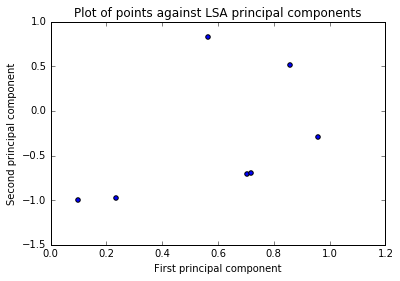

In [18]:
#Plot scatter plot of points
%pylab inline
import matplotlib.pyplot as plt
figure()
plt.scatter(xs,ys)
xlabel('First principal component')
ylabel('Second principal component')
title('Plot of points against LSA principal components')
show()

## Geometric picture

Populating the interactive namespace from numpy and matplotlib


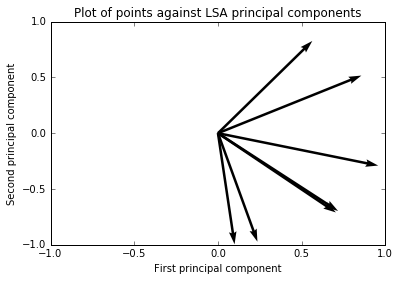

In [20]:
# Plot scatter plot of points with vectors
%pylab inline
import matplotlib.pyplot as plt
plt.figure()
ax = plt.gca()
ax.quiver(0,0,xs,ys,angles='xy',scale_units='xy',scale=1, linewidth = .01)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
xlabel('First principal component')
ylabel('Second principal component')
title('Plot of points against LSA principal components')
plt.draw()
plt.show()

* We have reduced dimension from 13-dim to 2-dim (and have lost some info)
* Similar docs point in similar directions. Dissimilar docs have perpendicular (orthogonal) vectors. "Cosine
similarity"
* Can use cosine similarity for search: which doc has the smallest angle with search term?

## Document similarity using LSA

In [22]:
#Compute document similarity using LSA components
similarity = np.asarray(numpy.asmatrix(dtm_lsa) * numpy.asmatrix(dtm_lsa).T)
pd.DataFrame(similarity,index=example, columns=example).head(10)

,Machine learning is super fun,"Python is super, super cool","Statistics is cool, too",Data science is fun,Python is great for machine learning,I like football,Football is great to watch
Machine learning is super fun,1.000000,0.669981,0.299536,0.879823,0.888530,0.383455,0.507335
"Python is super, super cool",0.669981,1.000000,0.908975,0.236612,0.254682,-0.428723,-0.299838
"Statistics is cool, too",0.299536,0.908975,1.000000,-0.189940,-0.171606,-0.766296,-0.670217
Data science is fun,0.879823,0.236612,-0.189940,1.000000,0.999826,0.776342,0.855956
Python is great for machine learning,0.888530,0.254682,-0.171606,0.999826,1.000000,0.764458,0.846169
I like football,0.383455,-0.428723,-0.766296,0.776342,0.764458,1.000000,0.990417
Football is great to watch,0.507335,-0.299838,-0.670217,0.855956,0.846169,0.990417,1.000000


# Summary

With aforementioned methods in place we now have a framework to load documents into our database and then query them using semantic search. This general method is what I would apply to the Patent database search problem definition.

## Improvements and next steps:

* Vectorize with TFIDF (term-frequency inverse document-frequency: uses overall frequency of words to weight
document-term matrix)
* Use LSA components as features in machine learning algorithm: clustering, classification, regression
* Alternative dimensionality reduction: Isomap, Random Matrix Methods, Laplacian Eigenmaps, Kernel PCA (cool
names!)